In [1]:
import PIL
from PIL import Image
import cv2
from pdf2image import convert_from_path
import numpy as np
import pytesseract
from pytesseract import Output
import pandas as pd

In [2]:
pages = convert_from_path('XYZ_CR_INV_001.pdf', 500)
pages[0].save('fak.jpg', "JPEG")

In [3]:
class Table:
    def __init__(self, x, y, w, h, image_text, columns_image):
        self.x= x
        self.y = y
        self.w = w
        self.h = h
        self.columns_image = self.get_image(columns_image)
        self.text_image = self.get_image(255-image_text)
        self.columns = self.get_columns()
        self.data_frame = pd.DataFrame.from_dict(dict([ (k,pd.Series(v)) for k,v in self.column_dict.items() ]))
#         print(self.column_dict)
        
    def get_image(self, image):
        return image[self.y : self.y + self.h, self.x : self.x + self.w]
    
    def get_columns(self):
        contours, hierarchy = cv2.findContours(self.columns_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        lines = []
        for cnt in contours:
            lines.append(cv2.boundingRect(cnt))
        lines.sort()
        
        columns = {}
        for index in range(len(lines[:-1])):
            x1 = lines[index][0] + lines[index][-2]
            x2 = lines[index+1][0]
            image = self.text_image[0:self.text_image.shape[1], x1:x2]
            columns[index] = Column(x1, x2, image)
        return columns
    
    @property
    def column_dict(self):
        return {column.header: column.rows for column in self.columns.values()}

In [4]:
class Column:
    def __init__(self, x1, x2, text_image):
        self.x1 = x1
        self.x2 = x2
        self.image = text_image
        self.header = ""
        self.rows = []
        self.process_image()
        
    def process_image(self):
        text = pytesseract.image_to_string(self.image, lang="eng")
        text = text.split("\n")
        text = [word for word in text if word]
        self.header = text[0]
        self.rows = text[1:]
     


In [5]:
def find_tables(image):
    (thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255-img_bin 
    
    # Defining a kernel length
    kernel_length = np.array(img).shape[1]//80
 
    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    #Image.fromarray(verticle_lines_img)
    
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    #Image.fromarray(horizontal_lines_img)
    
    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    mask = np.ones(img_final_bin.shape[:2], dtype="uint8") * 255
    cv2.drawContours(mask, contours, -1, 0, -1)
    mask= cv2.bitwise_not(mask)


#     mask = 255 - mask
    img_to_save = cv2.bitwise_and(img_bin, img_bin, mask=mask)
    tables = {}
    i = 0
    for h, c in zip(hierarchy[0], contours):
        
        if h[-1] == 0:
            #cv2.drawContours(img_final_bin, [c], -1, (0, 255, 0), 100) 
            x,y,w,h = cv2.boundingRect(c)
            if h > 50:
                tables[i] = Table(x, y, w, h, img_to_save, verticle_lines_img)
                i += 1
        
    for tab in tables.values():
        cv2.rectangle(img_bin, (tab.x, tab.y), (tab.x+tab.w, tab.y+tab.h), (0, 0, 0), -1)
    return tables, 255-img_bin

In [6]:
img = cv2.imread("fak.jpg", 0)

tables, img_without_tables = find_tables(img)

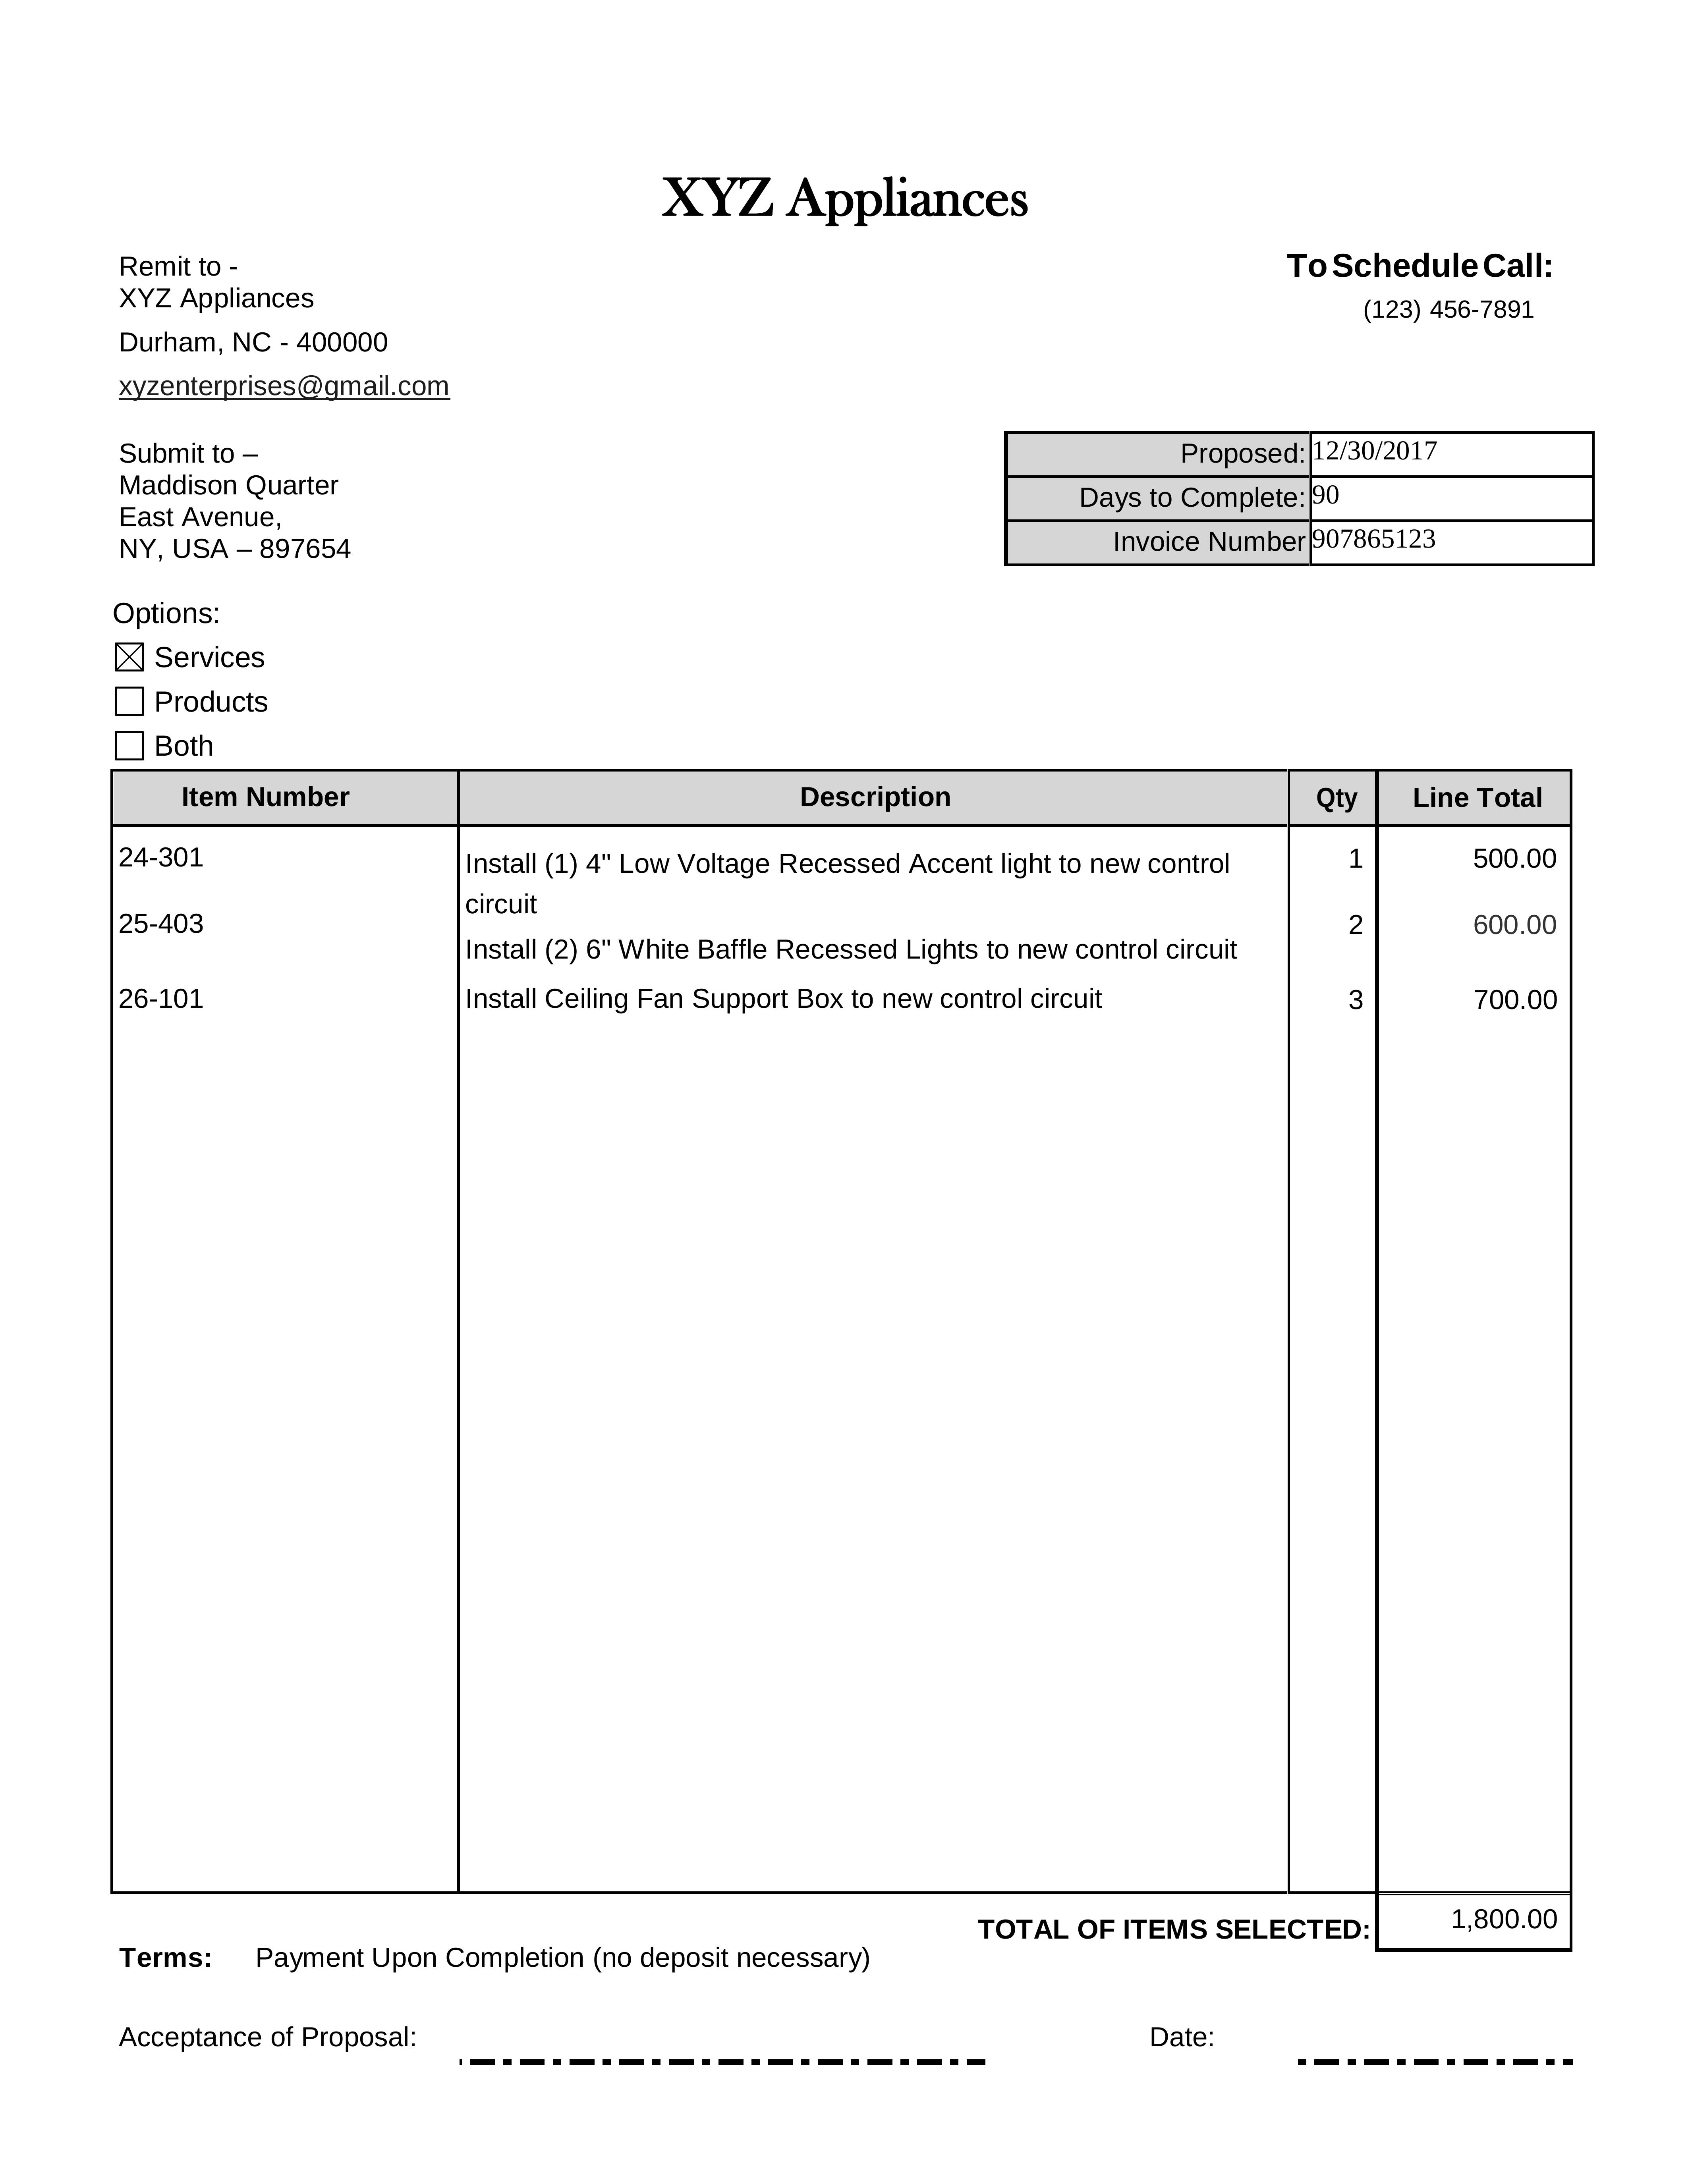

In [7]:
Image.fromarray(img)

In [8]:
tables[0].data_frame

,Item Number,Description,Qty,Line Total
0,24-301,"Install (1) 4"" Low Voltage Recessed Accent lig...",CTED:,500.00
1,25-403,circuit,NaN,600.00
2,26-101,"Install (2) 6"" White Baffle Recessed Lights to...",NaN,700.00
3,NaN,Install Ceiling Fan Support Box to new control...,NaN,"1,800.00"
4,NaN,TOTAL OF ITEMS SELE,NaN,NaN
5,NaN,cg ey,NaN,NaN


In [9]:
tables[1].data_frame

,Proposed:,12/30/2017
0,Days to Complete:,90
1,Invoice Number,907865123


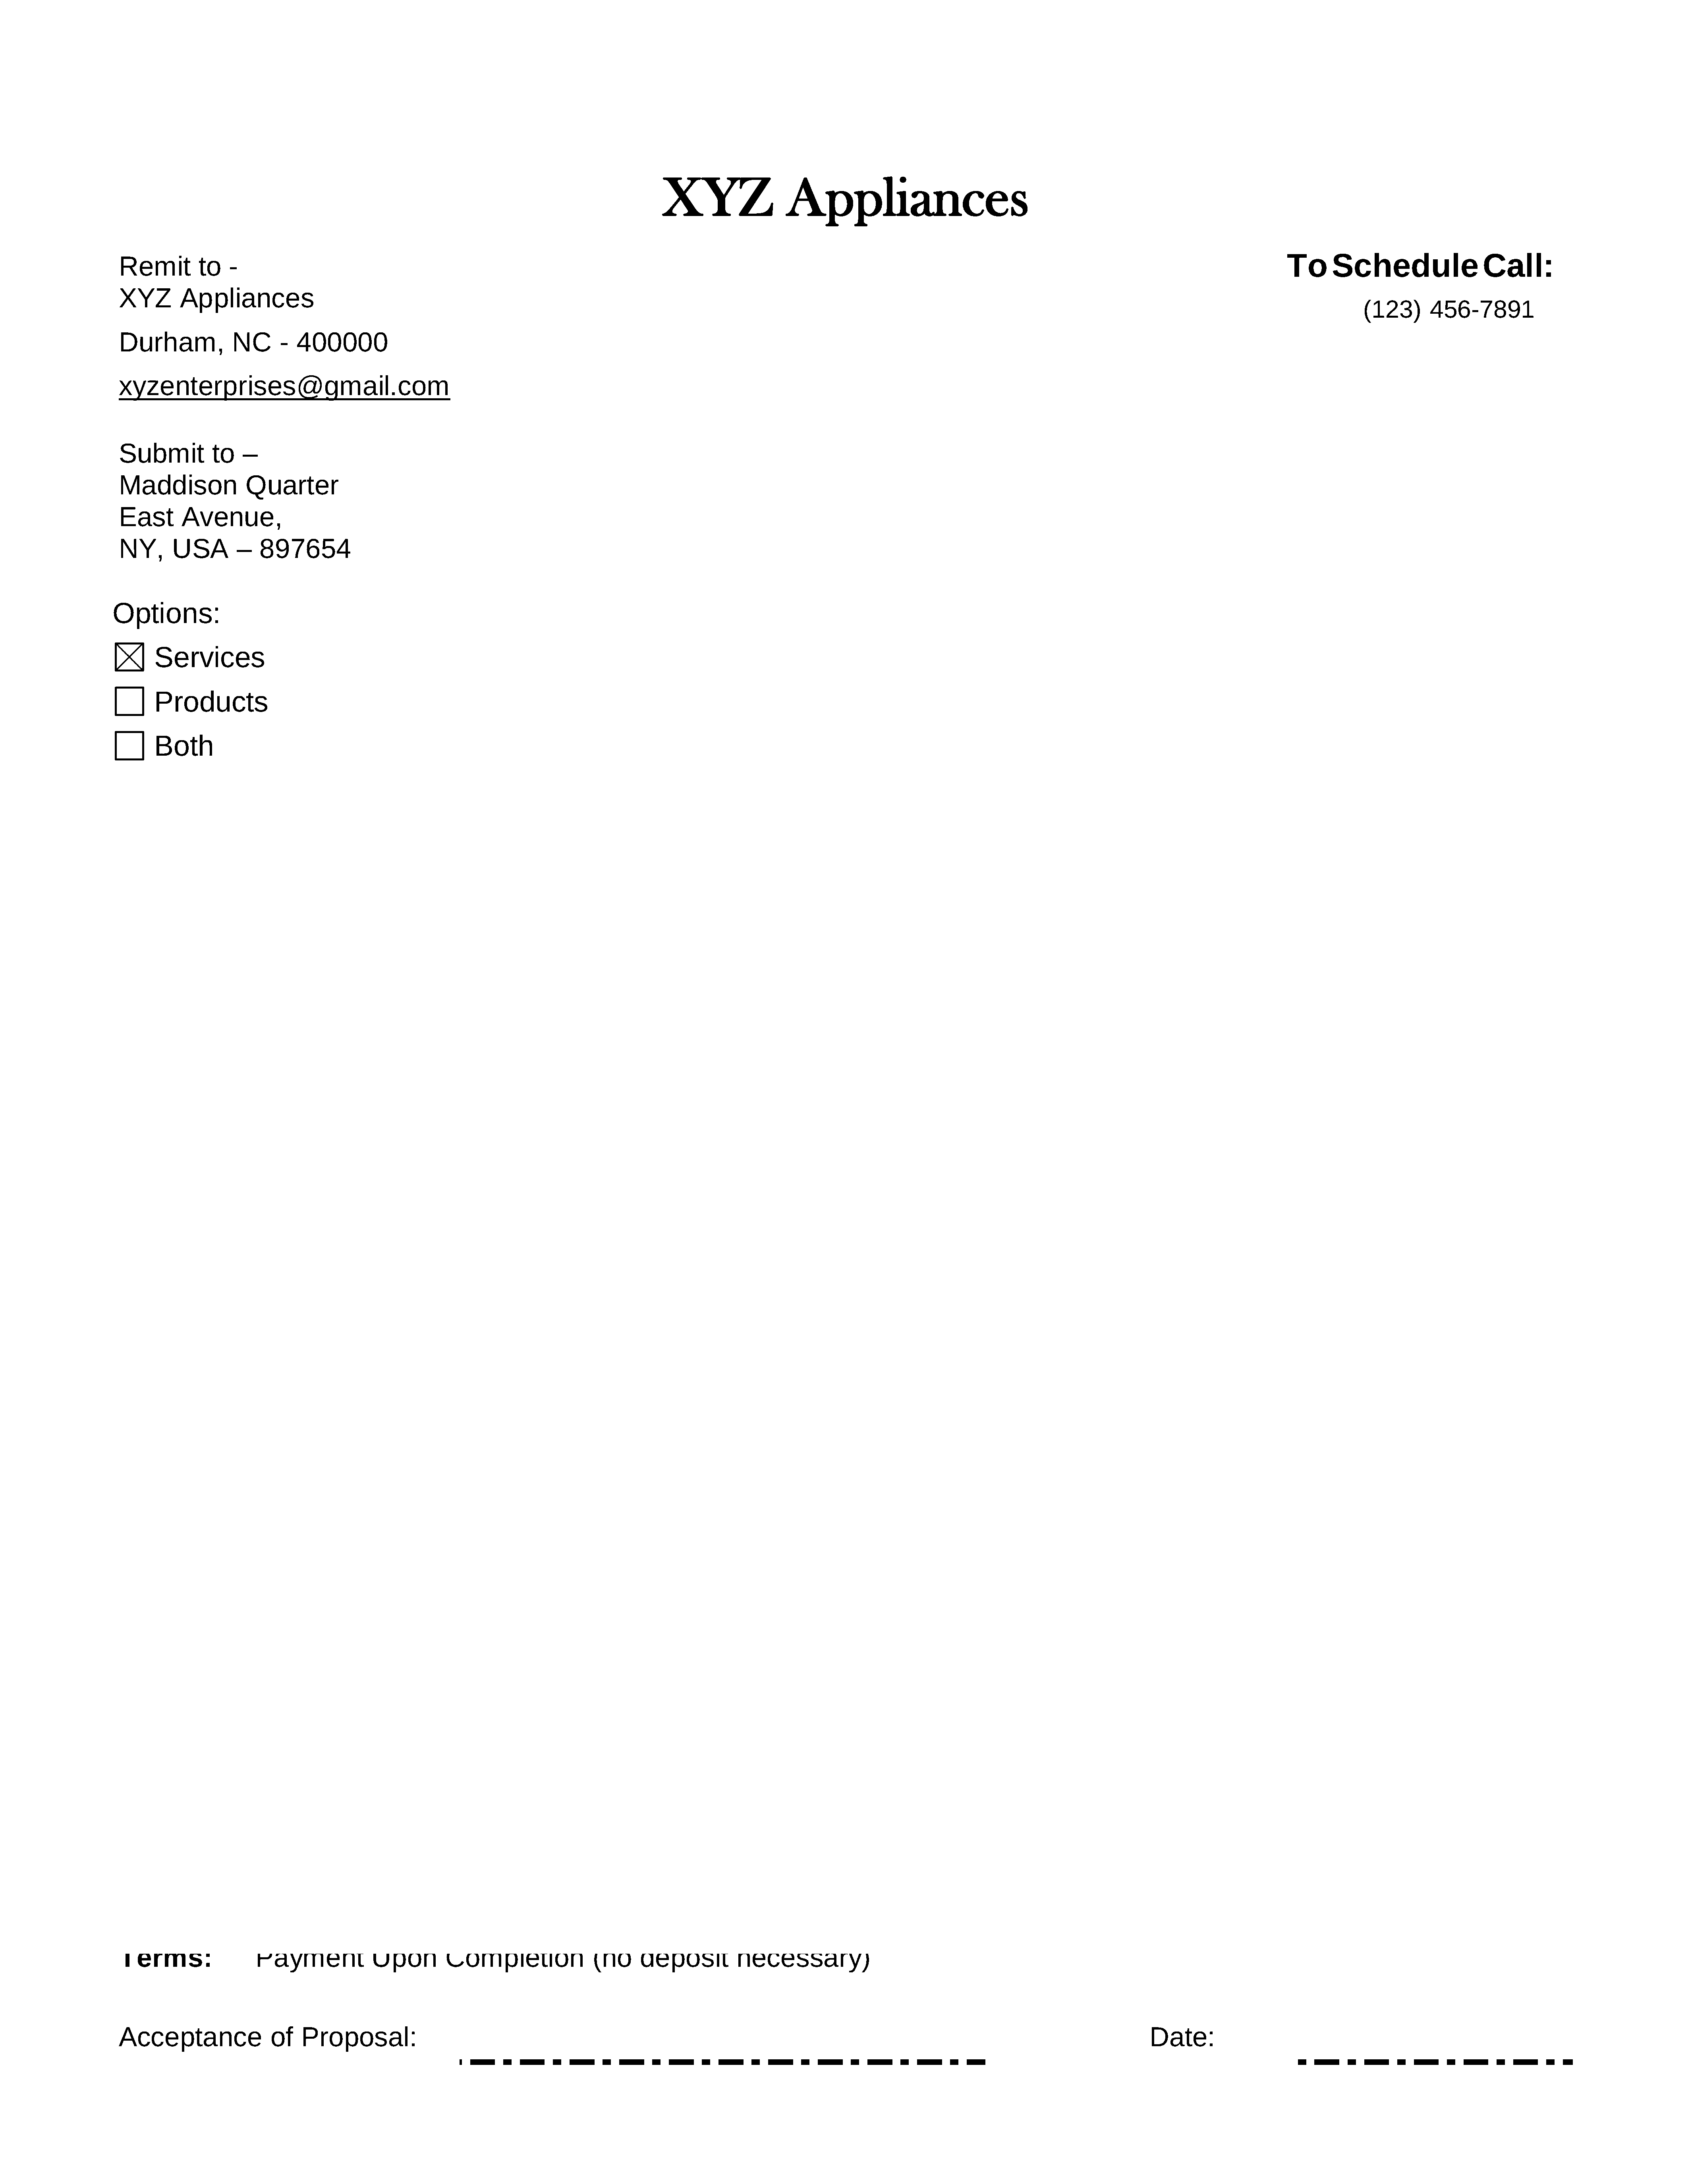

In [10]:
Image.fromarray(img_without_tables)

In [11]:
text = pytesseract.image_to_string(img_without_tables, lang="eng")

In [12]:
print(text)

XYZ Appliances

Remit to - To Schedule Call:
XYZ Appliances (123) 456-7891
Durham, NC - 400000

xyzenterprises@qmail.com

Submit to —
Maddison Quarter
East Avenue,

NY, USA — 897654

Options:
[x] Services
[_] Products
[_] Both

1erms: Payment UPON COMPIClION (NO GePOsit NeCessaly)

Acceptance of Proposal: Date:
